<a href="https://colab.research.google.com/github/abudubai16/CNN-using-transfer-learning-/blob/main/Pytorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the Dataset

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
dataset_path = "https://www.kaggle.com/datasets/mexwell/crop-diseases-classification"
od.download(dataset_path)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abhyudaychauhan
Your Kaggle Key: ··········


100%|██████████| 2.00G/2.00G [01:29<00:00, 23.9MB/s]


# Imports

In [3]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.io import read_image
from torchvision.models import inception_v3, Inception_V3_Weights
from torchsummary import summary

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from tqdm import tqdm

import os
import time
import json

# Data processing

In [4]:
csv_path = "/content/crop-diseases-classification/Data/train.csv"
img_dir = "/content/crop-diseases-classification/Data/train_images"
anot_path = "/content/crop-diseases-classification/Data/label_num_to_disease_map.json"

In [5]:
f = open(anot_path)
labels = json.load(f)
labels

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [6]:
df = pd.read_csv(csv_path)
df = df.sample(frac=1, random_state=1)
a = pd.get_dummies(df['label'])
b= df['image_id']
df = pd.concat([b,a], axis = 1)

In [7]:
df = df.to_numpy()

In [8]:
length = df.shape[0]
train_len = int(length*0.8)
val_len = int(length*0.1)

train_data = df[:train_len, :]
val_data = df[train_len: train_len+val_len, :]
test_data = df[train_len+val_len: , :]

In [9]:
def remove_invalid_images(arr):
  i = 0
  while i<len(arr):
    path = arr[i][0]
    if not os.path.exists(f"{img_dir}/{path}"):
      arr = np.delete(arr, (i), axis=0)
      i -= 1
    i += 1
  return arr, len(arr)

In [10]:
train_data, train_len = remove_invalid_images(train_data)
val_data, val_len = remove_invalid_images(val_data)
test_data, test_len = remove_invalid_images(test_data)

In [11]:
print(f"Train data len: {train_len}")
print(f"Validate data len: {val_len}")
print(f"Test data len: {test_len}")

Train data len: 14355
Validate data len: 1802
Test data len: 1781


# Create the Dataset


In [12]:
class ImageDataset(Dataset):
  def __init__(self, dataset, img_dir, transforms=None):
    super().__init__()
    self.dataset = dataset
    self.img_dir = img_dir
    self.transforms = transforms

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    img_path = f"{img_dir}/{self.dataset[index, 0]}"
    img = read_image(img_path)

    if self.transforms != None:
      img = self.transforms(img)

    y = self.dataset[index, 1:]
    y = torch.tensor([int(i) for i in y], dtype=torch.float32)
    return img, y

In [13]:
def create_transform(size: tuple):
  transforms = v2.Compose([
      v2.ToDtype(torch.float32, scale=True),
      v2.CenterCrop((512, 512)),
      v2.Resize(size=size)
  ])
  return transforms

In [14]:
transform = create_transform(size=(299, 299))
train_data = ImageDataset(train_data, img_dir, transform)
val_data = ImageDataset(val_data, img_dir, transform)
test_data = ImageDataset(test_data, img_dir, transform)

In [15]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=2)

In [16]:
for a, b in train_dataloader:
  print(a.shape,b.shape)
  break

torch.Size([32, 3, 299, 299]) torch.Size([32, 5])


# Create Model

In [17]:
class CNN(nn.Module):
  def __init__(self, num_channels, num_outputs):
    super(CNN, self).__init__()

    inception_layer = inception_v3(weights=Inception_V3_Weights,
                                   progress=False)
    for pos, layer in enumerate(inception_layer.children()):
      if pos < 18:
        for param in layer.parameters():
          param.requires_grad = False
    self.inception_layer = inception_layer

    self.dense = nn.Sequential(
        nn.Linear(1000, 250),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(250, num_outputs)
    )
  def forward(self, x):
    x = self.inception_layer(x)
    if len(x) == 2:
      x, _ = x
    logits = self.dense(x)
    return logits

In [18]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
model = CNN(3,5).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


In [19]:
summary(model, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

# Training functions

In [20]:
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()

In [31]:
def train(model, optim, train_dl, val_dl, l_fn, epochs):
  H = {
      'train_loss': [],
      'train_acc': [],
      'val_loss': [],
      'val_acc': [],
  }
  e0 = 0

  for e in range(epochs):
    model.train()

    print(f"------------------------------------------------------------")
    print(f"EPOCH : {e+1}")

    train_loss = 0
    val_loss = 0
    train_correct = 0
    val_correct = 0

    print("Training Step:")
    for _, (X, Y) in tqdm(enumerate(train_dl)):
      X, Y = (X.to(device), Y.to(device))

      # Forward prop
      pred = model(X)
      loss = l_fn(pred, Y)
      train_loss += loss.to("cpu").detach().numpy()

      # Back prop
      optim.zero_grad()
      loss.backward()
      optim.step()

      train_correct += sum([1 for i, val in enumerate(pred.argmax(1)) if int(val) == int(Y.argmax(1)[i])])

    print("\nValidation Step:")
    with torch.no_grad():
      model.eval()

      for _, (X, Y) in tqdm(enumerate(val_dl)):
        X, Y = (X.to(device), Y.to(device))

        pred = model(X)
        loss = l_fn(pred, Y)

        val_loss += loss.to("cpu").detach().numpy()
        val_correct += sum([1 for i, val in enumerate(pred.argmax(1)) if int(val) == int(Y.argmax(1)[i])])


    # Store the important specifications of the training process
    H["train_loss"].append(train_loss)
    H["train_acc"].append(train_correct / len(train_dl.dataset))
    H["val_loss"].append(val_loss)
    H["val_acc"].append(val_correct/ len(val_dl.dataset))

    # Print the messages appropriately
    print(f"\n\nTrain Loss : {train_loss}")
    print(f"Val Loss : {val_loss}")
    print(f"Train Accuracy : {train_correct/len(train_dl.dataset)}")
    print(f"Val Accuracy : {val_correct/len(val_dl.dataset)}")

    # Check for overfitting
    if len(H['val_acc']) > 1 and H['val_acc'][-1] < H['val_acc'][-2]:
      print("The model is showing signs of over fitting enter Y to continue, or N for breaking the training loop")
      t = input()
      if t == 'Y':
        continue
      else:
        return H, e
    e0 = e
  return H, e0

In [32]:
epochs = 10

startTime = time.time()
history, epochs = train(model, opt, train_dataloader, val_dataloader, loss_fn, epochs)
endTime = time.time()

print(f"Elapsed Time: {endTime-startTime}")

r_epochs = [i+1 for i in range(epochs)]

------------------------------------------------------------
EPOCH : 1
Training Step:


449it [02:09,  3.46it/s]



Validation Step:


57it [00:21,  2.65it/s]



Train Loss : 172.05543002858758
Val Loss : 58.681526988744736
Train Accuracy : 0.8626959247648903
Val Accuracy : 0.7391786903440621
------------------------------------------------------------
EPOCH : 2
Training Step:



449it [02:07,  3.53it/s]



Validation Step:


57it [00:21,  2.68it/s]



Train Loss : 112.24481160566211
Val Loss : 66.25640870630741
Train Accuracy : 0.9148032044583768
Val Accuracy : 0.755826859045505
------------------------------------------------------------
EPOCH : 3
Training Step:



449it [02:06,  3.56it/s]



Validation Step:


57it [00:21,  2.68it/s]




Train Loss : 76.27819766663015
Val Loss : 69.83683305978775
Train Accuracy : 0.942110762800418
Val Accuracy : 0.7491675915649278
The model is showing signs of over fitting enter Y to continue, or N for breaking the training loop
N
Elapsed Time: 463.99600768089294


In [36]:
r_epochs = [i+1 for i in range(3)]

Text(0.5, 1.0, 'Validation Accuracy')

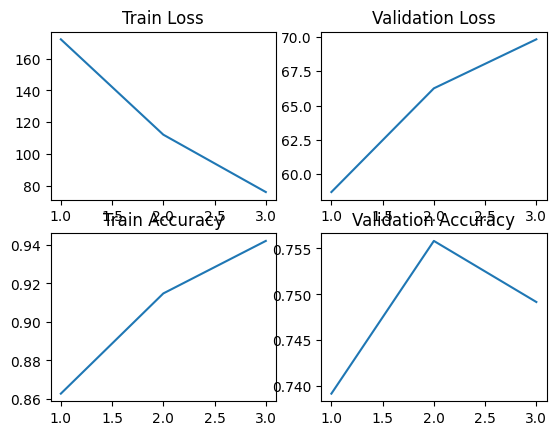

In [38]:
figure, axis = plt.subplots(2, 2)

axis[0, 0].plot(r_epochs, history['train_loss'])
axis[0, 0].set_title('Train Loss')

axis[0, 1].plot(r_epochs, history['val_loss'])
axis[0, 1].set_title('Validation Loss')

axis[1, 0].plot(r_epochs, history['train_acc'])
axis[1, 0].set_title('Train Accuracy')

axis[1, 1].plot(r_epochs, history['val_acc'])
axis[1, 1].set_title('Validation Accuracy')

In [63]:
def test_model(model, test_dl, loss_fn, labels):
  y_pred = []
  y_true = []
  test_loss = 0

  print(f"------------------------------------------------------------")
  print(f"Testing: ")

  with torch.no_grad():
      model.eval()

      for _, (X, Y) in tqdm(enumerate(test_dl)):
        X, Y = (X.to(device), Y.to(device))

        pred = model(X)
        loss = loss_fn(pred, Y).to("cpu").detach().numpy()

        test_loss += loss
        y_pred = y_pred + list(pred.argmax(1).to("cpu").numpy())
        y_true = y_true + list(Y.argmax(1).to("cpu").numpy())

  y_pred = np.array(y_pred)
  y_true = np.array(y_true)
  errors = y_pred-y_true
  error = 0
  for i in errors:
    error += 1 if i != 0 else 0

  print(error)

  # Reset the state of the model
  model.train()
  print(f"\n{y_true}\n{y_pred}")
  return test_acc, test_loss

In [ ]:
test_acc, test_loss = test_model(model, test_dataloader, loss_fn, [i for i in range(5)])

print(f"Test Report: \n {test_acc} \n")
print(f"Test loss: {test_loss}")

------------------------------------------------------------
Testing: 


7it [00:02,  2.68it/s]